In [51]:
#--------------------------------Cell 1 : Library and Environment Check.
import pandas
!pip install xgboost
!pip install seaborn


file_path = '/files/DSAP_Proj_FLFPGrowth/data/raw/children-per-woman-un.csv'
Adult_lit_fem_ds = pandas.read_csv(file_path)
print("File loaded successfully!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
File loaded successfully!


In [52]:
import pandas as pd
import os

# --- Cell 2: Load, Clean, and Filter Data (1991-2021) ---

base_dir = '/files/DSAP_Proj_FLFPGrowth/data/raw' 

files = {
    "Average Age of Mothers": 'average-age-of-mothers.csv',
    "Children per Woman": 'children-per-woman-un.csv',
    "Female Emp/Pop Ratio": 'modeled-female-employment-to-population-ratio.csv',
    "FLFP Rates": 'female-labor-force-participation-rates.csv',
    "GDP per Capita": 'gdp-per-capita-worldbank.csv',
    "Urban Population": 'urban-and-rural-population.csv',
    "Female Unemployment": 'unemployment-rate-women.csv',
    "Years of Schooling": 'years-of-schooling.csv'
}

def load_and_clean(path, name):
    try:
        df = pd.read_csv(path)
        
        # --- SPECIAL HANDLING 1: Average Age of Mothers ---
        if name == "Average Age of Mothers":
            # Remove "period-" from ALL column headers
            df.columns = df.columns.str.replace('period-', '', regex=False)
            
        # --- SPECIAL HANDLING 2: Children per Woman ---
        if name == "Children per Woman":
            # Rename the long column
            long_col = "Fertility rate - Sex: all - Age: all - Variant: estimates"
            if long_col in df.columns:
                df = df.rename(columns={long_col: "Children per Woman"})
            
            # CRITICAL FIX: Use lowercase 'time' as 'Year'
            if 'time' in df.columns:
                print(f"   -> Found 'time' column in {name}. Using it as Year.")
                df['Year'] = df['time']

        # --- GENERAL CLEANING (All Files) ---
        
        # 1. Standardize Country Column
        if 'Entity' not in df.columns:
            if 'Country Name' in df.columns: 
                df = df.rename(columns={'Country Name': 'Entity'})
            elif 'Country' in df.columns: 
                df = df.rename(columns={'Country': 'Entity'})

        # 2. Standardize Year Column & Filter
        if 'Year' in df.columns:
            # Force numeric (coercing errors handles any leftover text)
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
            
            # Remove rows where Year is invalid (NaN)
            df = df.dropna(subset=['Year'])
            
            # Convert to integer for clean look
            df['Year'] = df['Year'].astype(int)
            
            # Filter 1991-2021
            df_filtered = df[(df['Year'] >= 1991) & (df['Year'] <= 2021)].copy()
            
            # DEBUG: If rows are still missing, warn the user
            if len(df_filtered) < 300:
                print(f"WARNING: {name} still has only {len(df_filtered)} rows. Columns found: {df.columns.tolist()}")
                
            return df_filtered
        
        else:
            print(f"Error: Could not find 'Year' column in {name}")
            return pd.DataFrame()

    except Exception as e:
        print(f"Failed to load {name}: {e}")
        return pd.DataFrame()

# Load all files
data_frames = {}
print("--- Loading Files ---")
for name, filename in files.items():
    full_path = os.path.join(base_dir, filename)
    data_frames[name] = load_and_clean(full_path, name)

# Extract to variables
av_age_mothers_df = data_frames["Average Age of Mothers"]
child_per_wom_df = data_frames["Children per Woman"]
f_emp_pop_ratio_df = data_frames["Female Emp/Pop Ratio"]
FLFP_rates_df = data_frames["FLFP Rates"]
gdp_per_capita_df = data_frames["GDP per Capita"]
LT_urban_pop_df = data_frames["Urban Population"]
Unemp_rate_f_df = data_frames["Female Unemployment"]
years_school_df = data_frames["Years of Schooling"]

# Final Verification
print("\n--- Final Row Counts (1991-2021) ---")
for name, df in data_frames.items():
    print(f"{name}: {len(df):,} rows")

--- Loading Files ---

--- Final Row Counts (1991-2021) ---
Average Age of Mothers: 7,843 rows
Children per Woman: 7,843 rows
Female Emp/Pop Ratio: 6,200 rows
FLFP Rates: 6,200 rows
GDP per Capita: 6,419 rows
Urban Population: 7,068 rows
Female Unemployment: 6,200 rows
Years of Schooling: 6,074 rows


In [53]:
# --- Cell 3: Complete Cleaner & Merge ---

import pandas as pd
import gc

# 1. List of ALL 8 DataFrames (from Cell 2)
dfs_to_merge = [
    av_age_mothers_df, 
    child_per_wom_df, 
    f_emp_pop_ratio_df, 
    FLFP_rates_df, 
    gdp_per_capita_df,  # This is the one that was giving us trouble
    LT_urban_pop_df, 
    Unemp_rate_f_df, 
    years_school_df
]

# 2. Define the Cleaning Function
# This runs on EVERY file before merging to ensure keys match perfectly
def clean_and_prep(df, index):
    # Work on a copy
    df = df.copy()
    
    # A. Standardize Column Names
    # Remove whitespace from column headers (e.g. " Year" -> "Year")
    df.columns = df.columns.str.strip()
    
    if 'Country Code' in df.columns: df = df.rename(columns={'Country Code': 'Code'})
    if 'Country Name' in df.columns: df = df.rename(columns={'Country Name': 'Entity'})
    elif 'Country' in df.columns: df = df.rename(columns={'Country': 'Entity'})
        
    # B. CRITICAL: Clean the Keys (Code and Year)
    if 'Code' not in df.columns or 'Year' not in df.columns:
        print(f"⚠️ Warning: DF #{index} missing 'Code' or 'Year'. Skipping.")
        return None, None
    
    # Drop rows with missing keys
    df = df.dropna(subset=['Code', 'Year'])

    # 1. Clean CODE: Force to string, STRIP HIDDEN SPACES
    df['Code'] = df['Code'].astype(str).str.strip()
    
    # 2. Clean YEAR: Force to integer
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].astype(int)

    # C. Remove Duplicates (1 row per Country-Year)
    df = df.drop_duplicates(subset=['Code', 'Year'])

    # D. Separate Data from Country Name
    # We save the name map now, but drop the column to save memory during merge
    code_map = {}
    if 'Entity' in df.columns:
        code_map = df[['Code', 'Entity']].drop_duplicates().set_index('Code')['Entity'].to_dict()
        df = df.drop(columns=['Entity']) 
        
    return df, code_map

# 3. Initialize the Master DataFrame
print("--- Starting Full Merge of 8 Files ---")

# Prep the first file
df_master, master_code_map = clean_and_prep(dfs_to_merge[0], 0)
print(f"Initialized with {len(df_master)} rows.")

# 4. Loop and Merge the Rest
for i in range(1, len(dfs_to_merge)):
    # Prep current file
    current_df, current_map = clean_and_prep(dfs_to_merge[i], i)
    
    if current_df is not None:
        # Update name list
        master_code_map.update(current_map)
        
        # Merge (Outer Join)
        try:
            df_master = pd.merge(df_master, current_df, on=['Code', 'Year'], how='outer')
        except Exception as e:
            print(f"❌ Merge failed at file #{i}: {e}")
        
        # Memory Cleanup
        del current_df
        gc.collect()

# 5. Finish Up
# Re-attach Country Names
df_master['Country'] = df_master['Code'].map(master_code_map)

# Organize Columns
cols = ['Country', 'Code', 'Year'] + [c for c in df_master.columns if c not in ['Country', 'Code', 'Year']]
df_master = df_master[cols]
df_master = df_master.sort_values(by=['Country', 'Year']).reset_index(drop=True)

print("\n✅ Merge Complete!")
print(f"Final Shape: {df_master.shape}")

# 6. Verify GDP Column
# Check if we successfully captured the GDP data this time
gdp_cols = [c for c in df_master.columns if "GDP" in c]
if gdp_cols:
    count = df_master[gdp_cols[0]].count()
    print(f"GDP Data Points: {count} (Target: ~6000)")
else:
    print("❌ GDP Column still missing!")

--- Starting Full Merge of 8 Files ---
Initialized with 7378 rows.

✅ Merge Complete!
Final Shape: (7409, 13)
GDP Data Points: 6047 (Target: ~6000)


In [54]:
# --- Cell 4: Rename and Organize Columns (Robust) ---

import pandas as pd

# 1. Define the Mapping (Keyword -> New Name)
# We use broader keywords (e.g., "Fertility") to catch the column 
# even if the specific rename in Cell 2 failed.
rename_map = {
    "age at childbearing": "Mean_Age_Mothers",
    "Fertility": "Fertility_Rate",         # <--- Changed from "Children per Woman" to "Fertility"
    "Employment to population": "Fem_Emp_Pop_Ratio",
    "Labor force participation": "FLFP_Rate",
    "GDP per capita": "GDP_Per_Capita",
    "Urban population": "Urban_Pop_Rate",
    "Unemployment, female": "Fem_Unemp_Rate",
    "years of schooling": "Years_Schooling"
}

# 2. Apply Renaming
print("--- Renaming Columns ---")
new_columns = df_master.columns.tolist()

for i, col in enumerate(new_columns):
    for keyword, short_name in rename_map.items():
        # Case-insensitive match (e.g., "fertility" matches "Fertility rate...")
        if keyword.lower() in col.lower():
            new_columns[i] = short_name
            break 
            
df_master.columns = new_columns

# 3. Define the Desired Order
desired_order = [
    'Country', 'Code', 'Year', 
    'FLFP_Rate', 
    'Fem_Emp_Pop_Ratio', 
    'Fem_Unemp_Rate', 
    'Mean_Age_Mothers', 
    'GDP_Per_Capita', 
    'Urban_Pop_Rate', 
    'Years_Schooling',
    'Fertility_Rate' 
]

# 4. Reorder Columns
# Check which columns we actually have
existing_cols = [c for c in desired_order if c in df_master.columns]
missing_cols = [c for c in desired_order if c not in df_master.columns]

if missing_cols:
    print(f"⚠️ Warning: The following columns are still missing: {missing_cols}")
    print(f"   -> Available columns in df_master: {df_master.columns.tolist()}")

# Create the final dataframe with the existing columns
df_master = df_master[existing_cols]

# 5. Final Preview
print("\n✅ Renaming & Reordering Complete!")
print(f"Final Columns: {df_master.columns.tolist()}")

print("\n--- First 5 Rows ---")
pd.set_option('display.max_columns', None) 
print(df_master.head())

--- Renaming Columns ---

✅ Renaming & Reordering Complete!
Final Columns: ['Country', 'Code', 'Year', 'FLFP_Rate', 'Fem_Emp_Pop_Ratio', 'Fem_Unemp_Rate', 'Mean_Age_Mothers', 'GDP_Per_Capita', 'Urban_Pop_Rate', 'Years_Schooling', 'Fertility_Rate']

--- First 5 Rows ---
       Country Code  Year  FLFP_Rate  Fem_Emp_Pop_Ratio  Fem_Unemp_Rate  \
0  Afghanistan  AFG  1991     15.740             14.075          10.580   
1  Afghanistan  AFG  1992     15.660             14.013          10.515   
2  Afghanistan  AFG  1993     15.544             13.930          10.379   
3  Afghanistan  AFG  1994     15.393             13.806          10.310   
4  Afghanistan  AFG  1995     15.226             13.656          10.310   

   Mean_Age_Mothers  GDP_Per_Capita  Urban_Pop_Rate  Years_Schooling  \
0            29.677             NaN       2602720.0         0.218944   
1            29.697             NaN       2835725.0         0.236229   
2            29.716             NaN       3204414.0         0.2

In [55]:
# --- Cell 5: Filter Non-Countries, Remove Empty Rows, and Save ---

import pandas as pd

# 1. Define Non-Country Entities to Remove
entities_to_drop = [
    "World",
    "Arab World", "European Union", "OECD members",
    "High income", "Upper middle income", "Middle income", 
    "Lower middle income", "Low income", "Sub-Saharan Africa",
    "East Asia & Pacific", "Europe & Central Asia", 
    "Latin America & Caribbean", "Middle East & North Africa",
    "North America", "South Asia"
]

# 2. Define Missing Data Threshold (0.25 = 25%)
MISSING_THRESHOLD = 0.25 

# --- EXECUTE FILTERING ---

print(f"Original Country Count: {df_master['Country'].nunique()}")

# A. Remove known non-country entities
df_clean = df_master[~df_master['Country'].isin(entities_to_drop)].copy()

# B. Remove "High Missingness" Countries
# FIX: We split the DataFrame to calculate missingness safely on all versions
# We group by 'Country' using the column itself, but calculate on the DATA columns only
data_cols = [c for c in df_clean.columns if c != 'Country']

# Calculate % missing for each country (Sum of NaNs / Total Cells)
missing_series = df_clean[data_cols].groupby(df_clean['Country']).apply(lambda x: x.isnull().sum().sum() / x.size)

bad_countries = missing_series[missing_series > MISSING_THRESHOLD].index.tolist()

# Drop them
df_clean = df_clean[~df_clean['Country'].isin(bad_countries)]

# C. Drop the useless "OWID" column if it exists
if "World regions according to OWID" in df_clean.columns:
    df_clean = df_clean.drop(columns=["World regions according to OWID"])

# --- SAVE AND SUMMARY ---

# Save to CSV
output_filename = 'master_dataset_clean.csv'
df_clean.to_csv(output_filename, index=False)

print(f"\n✅ Filtering Complete!")
print(f"Removed Manual List: {len(df_master['Country'].unique()) - len(df_master[~df_master['Country'].isin(entities_to_drop)]['Country'].unique())} entities")
print(f"Removed High-Missingness Countries: {len(bad_countries)}")
print(f"   -> Dropped: {bad_countries}")
print(f"Final Country Count: {df_clean['Country'].nunique()}")
print(f"Saved to: {output_filename}")

# Final Stats
print("\n--- Final Data Completeness ---")
print(df_clean.count())

Original Country Count: 239

✅ Filtering Complete!
Removed Manual List: 1 entities
Removed High-Missingness Countries: 52
   -> Dropped: ['American Samoa', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bermuda', 'Bonaire Sint Eustatius and Saba', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Cook Islands', 'Curacao', 'Dominica', 'Falkland Islands', 'Faroe Islands', 'French Guiana', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guernsey', 'Isle of Man', 'Jersey', 'Kiribati', 'Kosovo', 'Liechtenstein', 'Marshall Islands', 'Martinique', 'Mayotte', 'Micronesia (country)', 'Monaco', 'Montserrat', 'Nauru', 'Niue', 'Northern Mariana Islands', 'Palau', 'Reunion', 'Saint Barthelemy', 'Saint Helena', 'Saint Kitts and Nevis', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'San Marino', 'Seychelles', 'Sint Maarten (Dutch part)', 'Taiwan', 'Tokelau', 'Turks and Caicos Islands', 'Tuvalu', 'Vatican', 'Wallis and Futuna', 'Western Sahara']
Final Country Co

In [56]:
# --- Cell 6: Feature Engineering & Time Series Split ---

import pandas as pd
import numpy as np

# 1. Filter for Shifted 5-Year Intervals
# We align with your data availability (starting 1991 to capture the first wave of labor data)
years_of_interest = [1991, 1996, 2001, 2006, 2011, 2016, 2021]

# Filter the cleaned master dataset
df_panel = df_clean[df_clean['Year'].isin(years_of_interest)].copy()

# Sort is critical for the 'shift' operation so we calculate growth within the correct country
df_panel = df_panel.sort_values(by=['Code', 'Year'])

# 2. Calculate the Target: Future FLFP Growth (Next 5 Years)
# Formula: (FLFP in t+5 - FLFP in t) / FLFP in t
# We use 'shift(-1)' to grab the NEXT row's value (because we filtered for 5-year gaps)
df_panel['Next_FLFP'] = df_panel.groupby('Code')['FLFP_Rate'].shift(-1)
df_panel['FLFP_Growth_Next_5Y'] = (df_panel['Next_FLFP'] - df_panel['FLFP_Rate']) / df_panel['FLFP_Rate']

# 3. Drop "End of Line" Rows
# The year 2021 (or the last available year) cannot predict the future because there is no 2026 data.
# We drop rows where the target is NaN.
df_model = df_panel.dropna(subset=['FLFP_Growth_Next_5Y']).copy()

# 4. Define Predictors (X) and Target (y)
# These are the variables you mentioned in your project description
X_cols = [
    'Fem_Emp_Pop_Ratio', 
    'Fem_Unemp_Rate', 
    'Mean_Age_Mothers', 
    'GDP_Per_Capita', 
    'Urban_Pop_Rate', 
    'Years_Schooling', 
    'Fertility_Rate'
]
y_col = 'FLFP_Growth_Next_5Y'

# 5. Perform the Temporal Split (Option 1)
# Train: 1991 - 2006 (Predicts outcomes for 1996, 2001, 2006, 2011)
# Test:  2011 - 2016 (Predicts outcomes for 2016, 2021)

train_years = [1991, 1996, 2001, 2006]
test_years = [2011, 2016]

train_mask = df_model['Year'].isin(train_years)
test_mask = df_model['Year'].isin(test_years)

X_train = df_model.loc[train_mask, X_cols]
y_train = df_model.loc[train_mask, y_col]

X_test = df_model.loc[test_mask, X_cols]
y_test = df_model.loc[test_mask, y_col]

# 6. Verify Data Integrity
print(f"--- Data Split Summary (1991-2021 Shift) ---")
print(f"Training Samples ({min(train_years)}-{max(train_years)}): {X_train.shape[0]}")
print(f"Testing Samples  ({min(test_years)}-{max(test_years)}): {X_test.shape[0]}")

# Check for Empty Test Set (Risk: Do we have 2021 data to generate the 2016 target?)
if X_test.shape[0] < 50:
    print("\n⚠️ WARNING: Test set is small. You might be missing 2021 FLFP data.")
else:
    print("\n✅ Split looks healthy and ready for modeling.")

print("\n--- Example: Predictor Row (1991) -> Target (Growth to 1996) ---")
# Show columns to verify the calculation
preview_cols = ['Country', 'Year', 'FLFP_Rate', 'Next_FLFP', 'FLFP_Growth_Next_5Y']
print(df_model.loc[train_mask, preview_cols].head(3))

--- Data Split Summary (1991-2021 Shift) ---
Training Samples (1991-2006): 744
Testing Samples  (2011-2016): 372

✅ Split looks healthy and ready for modeling.

--- Example: Predictor Row (1991) -> Target (Growth to 1996) ---
        Country  Year  FLFP_Rate  Next_FLFP  FLFP_Growth_Next_5Y
0   Afghanistan  1991     15.740     15.044            -0.044219
5   Afghanistan  1996     15.044     14.223            -0.054573
10  Afghanistan  2001     14.223     14.472             0.017507


In [57]:
# --- Cell 7: Model Training and Evaluation ---

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. Setup Models
# We use a dictionary to easily loop through them
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0), # L2 Regularization
    "Lasso Regression": Lasso(alpha=0.01), # L1 Regularization (Good for feature selection)
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# 2. Define Validation Strategy
# 5-Fold CV: Splits the training data into 5 parts to ensure the model isn't just memorizing
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

print("--- Model Performance ---")
print(f"{'Model':<20} | {'CV R2 (Train)':<15} | {'Test RMSE':<12} | {'Test R2':<10}")
print("-" * 65)

# 3. Training Loop
for name, model in models.items():
    
    # Create Pipeline: 
    # 1. Imputer: Fills any tiny gaps (safety net)
    # 2. Scaler: Standardizes data (Crucial for Linear/Ridge/Lasso)
    # 3. Model: The regressor itself
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    
    # A. Cross-Validation on Training Set (1991-2006)
    # This tells us how stable the model is on historical data
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')
    mean_cv_r2 = cv_scores.mean()
    
    # B. Train on Full Training Set
    pipeline.fit(X_train, y_train)
    
    # C. Predict on Test Set (2011-2016)
    # This is the "Moment of Truth" - predicting the future
    y_pred = pipeline.predict(X_test)
    
    # D. Calculate Metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "CV_R2": mean_cv_r2,
        "Test_RMSE": test_rmse,
        "Test_R2": test_r2,
        "Pipeline": pipeline # Save the trained model for later (SHAP)
    })
    
    print(f"{name:<20} | {mean_cv_r2:.4f}          | {test_rmse:.4f}       | {test_r2:.4f}")

# 4. Save best model for interpretation
# We sort by Test R2 to find the winner
results_df = pd.DataFrame(results).sort_values(by='Test_R2', ascending=False)
best_model_name = results_df.iloc[0]['Model']
best_pipeline = results_df.iloc[0]['Pipeline']

print(f"\n✅ Best Model: {best_model_name}")

--- Model Performance ---
Model                | CV R2 (Train)   | Test RMSE    | Test R2   
-----------------------------------------------------------------
Linear Regression    | 0.1140          | 0.0797       | -0.0022
Ridge Regression     | 0.1141          | 0.0797       | -0.0022
Lasso Regression     | 0.0617          | 0.0804       | -0.0213
Random Forest        | 0.0549          | 0.0807       | -0.0292
XGBoost              | 0.0325          | 0.0825       | -0.0747

✅ Best Model: Ridge Regression


/tmp/ipykernel_59/1360111104.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')


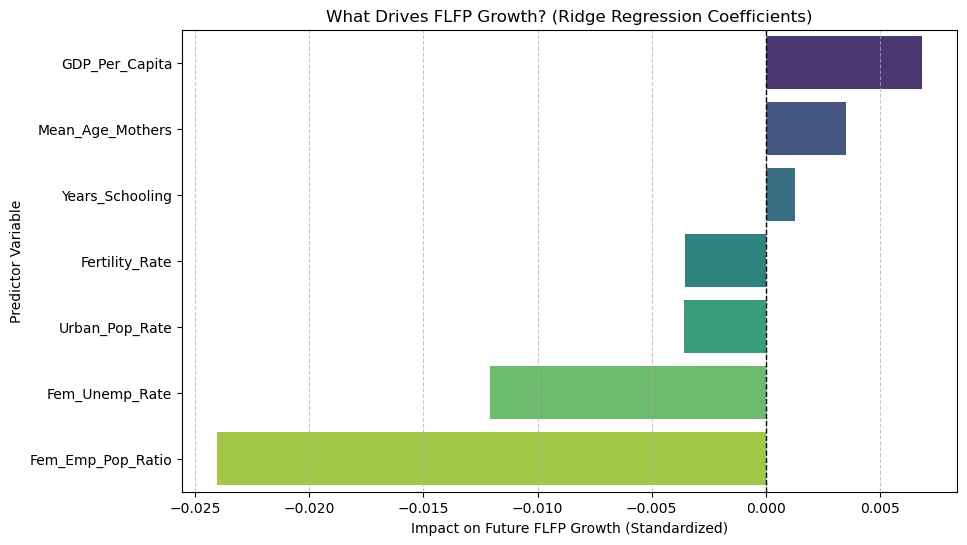

--- Feature Impacts (Standardized) ---
             Feature  Coefficient
3     GDP_Per_Capita     0.006836
2   Mean_Age_Mothers     0.003511
5    Years_Schooling     0.001298
6     Fertility_Rate    -0.003529
4     Urban_Pop_Rate    -0.003576
1     Fem_Unemp_Rate    -0.012078
0  Fem_Emp_Pop_Ratio    -0.024035


In [59]:
# --- Cell 8: Visualize Ridge Coefficients ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract the model and feature names
# We access the 'model' step from your best_pipeline
ridge_model = best_pipeline.named_steps['model']
feature_names = X_cols

# 2. Get the Coefficients
# These numbers tell us the slope of the line for each variable
coefficients = ridge_model.coef_

# 3. Create a DataFrame for Plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')

# Add a vertical line at 0 for clarity
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.title('What Drives FLFP Growth? (Ridge Regression Coefficients)')
plt.xlabel('Impact on Future FLFP Growth (Standardized)')
plt.ylabel('Predictor Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 5. Print the exact numbers
print("--- Feature Impacts (Standardized) ---")
print(coef_df)

/tmp/ipykernel_59/172730964.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


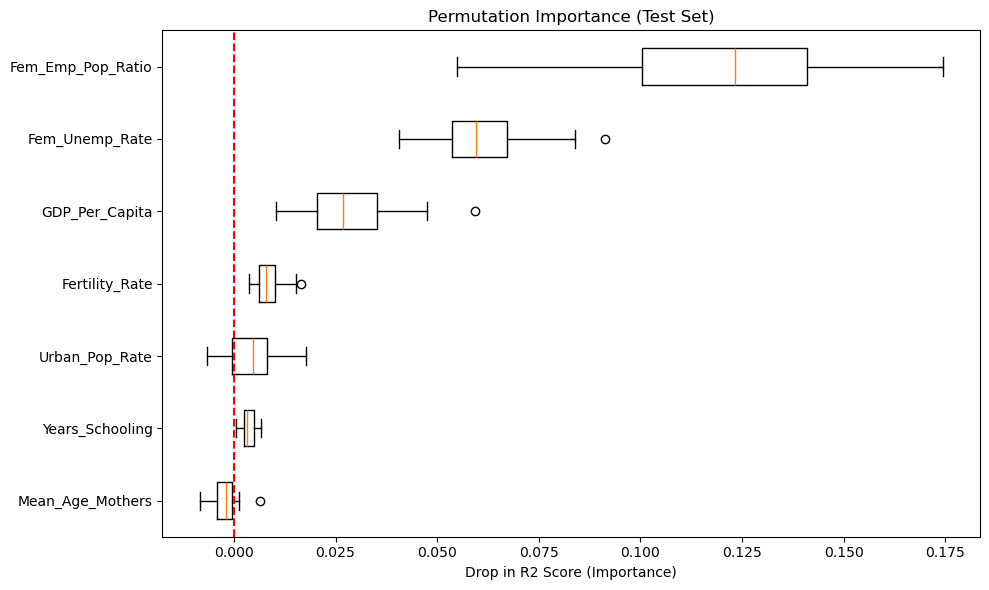

--- Feature Importance (Ranked) ---
             Feature  Importance_Mean  Importance_Std
0  Fem_Emp_Pop_Ratio         0.119352        0.029367
1     Fem_Unemp_Rate         0.060750        0.012225
3     GDP_Per_Capita         0.028284        0.011377
6     Fertility_Rate         0.008635        0.003161
4     Urban_Pop_Rate         0.004094        0.006201
5    Years_Schooling         0.003524        0.001579
2   Mean_Age_Mothers        -0.002232        0.002847


In [60]:
# --- Cell 9: Permutation Importance (Verification) ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# 1. Calculate Permutation Importance
# We use the Test set to see what actually drives generalization to the future
# n_repeats=30 means we shuffle each column 30 times to get a stable score
perm_importance = permutation_importance(
    best_pipeline, X_test, y_test, 
    n_repeats=30, random_state=42, scoring='r2'
)

# 2. Organize Data
sorted_idx = perm_importance.importances_mean.argsort()
features = np.array(X_cols)

# 3. Plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    labels=features[sorted_idx]
)
plt.title("Permutation Importance (Test Set)")
plt.xlabel("Drop in R2 Score (Importance)")
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# 4. Print Summary
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("--- Feature Importance (Ranked) ---")
print(importance_df)

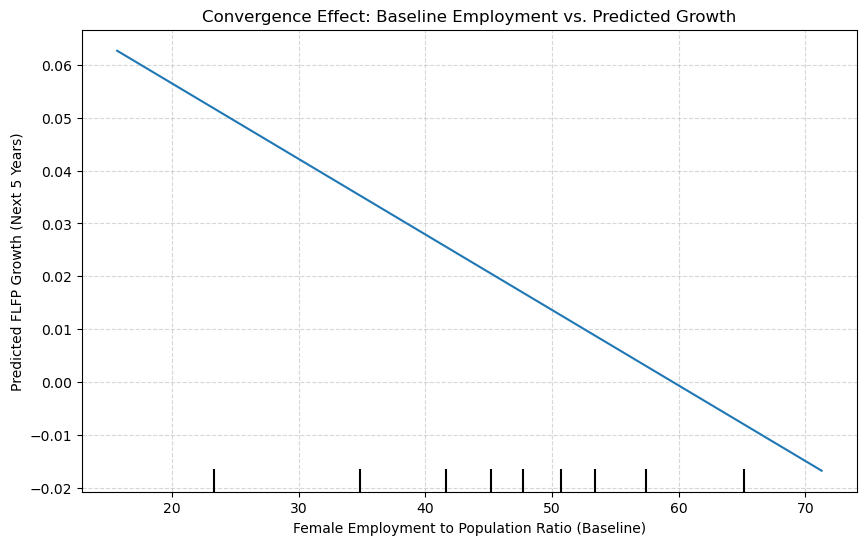

In [62]:
# --- Cell 10: Partial Dependence Plot (The Convergence Effect) ---

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 1. Setup the plot
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Calculate Partial Dependence
# We removed 'line_kws' to make it compatible with your sklearn version
PartialDependenceDisplay.from_estimator(
    best_pipeline, 
    X_test, 
    features=['Fem_Emp_Pop_Ratio'], 
    kind='average',
    ax=ax
)

plt.title(f"Convergence Effect: Baseline Employment vs. Predicted Growth")
plt.xlabel("Female Employment to Population Ratio (Baseline)")
plt.ylabel("Predicted FLFP Growth (Next 5 Years)")
plt.grid(linestyle='--', alpha=0.5)
plt.show()

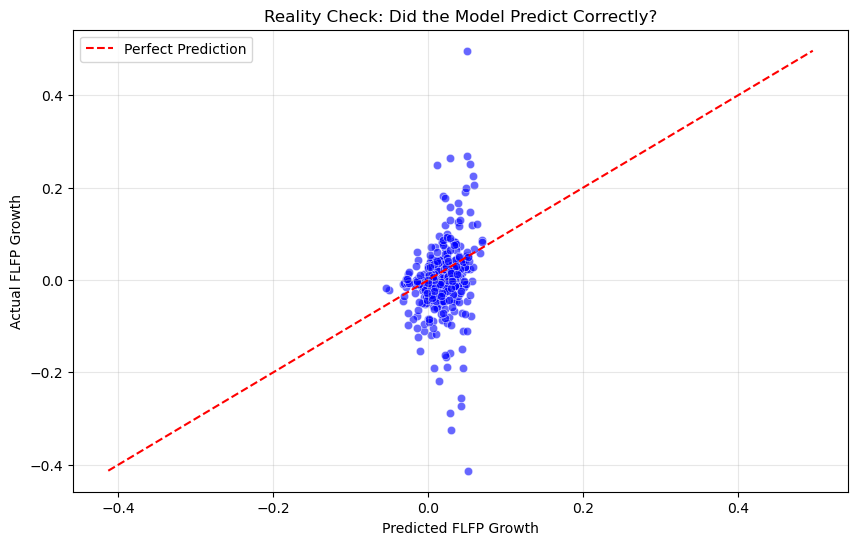

--- Top 5 'Miracle' Countries (Overperformers) ---
           Country  Year  Actual_Growth  Predicted_Growth  Residual
5822  Saudi Arabia  2016       0.496501          0.050525  0.445976
769        Bolivia  2016       0.248406          0.011145  0.237261
521     Bangladesh  2016       0.263994          0.027964  0.236030
20     Afghanistan  2011       0.268072          0.049381  0.218690
4050         Malta  2011       0.251549          0.053412  0.198136


In [63]:
# --- Cell 11: Predicted vs. Actual Growth (The "Reality Check") ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict on the Test Set again
y_pred = best_pipeline.predict(X_test)

# 2. Create a Comparison DataFrame
results_df = X_test.copy()
results_df['Actual_Growth'] = y_test
results_df['Predicted_Growth'] = y_pred
results_df['Residual'] = results_df['Actual_Growth'] - results_df['Predicted_Growth']

# Add Country and Year back for context (we align by index)
results_df['Country'] = df_model.loc[X_test.index, 'Country']
results_df['Year'] = df_model.loc[X_test.index, 'Year']

# 3. Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Predicted_Growth', y='Actual_Growth', alpha=0.6, color='blue')

# Add the perfect prediction line (45 degrees)
min_val = min(results_df['Actual_Growth'].min(), results_df['Predicted_Growth'].min())
max_val = max(results_df['Actual_Growth'].max(), results_df['Predicted_Growth'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.title('Reality Check: Did the Model Predict Correctly?')
plt.xlabel('Predicted FLFP Growth')
plt.ylabel('Actual FLFP Growth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Highlight the "Miracle" Countries (Top Overperformers)
# These are countries that grew MUCH faster than their economic baseline suggested they should.
overperformers = results_df.sort_values(by='Residual', ascending=False).head(5)

print("--- Top 5 'Miracle' Countries (Overperformers) ---")
print(overperformers[['Country', 'Year', 'Actual_Growth', 'Predicted_Growth', 'Residual']])